In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [4]:
data = pd.read_csv('retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [16]:
data.user_id.unique().shape

(2499,)

In [21]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

# Оценивание
За выполнени каждого задания 1 балл

4 балла -> отл

3 балла -> хор

И тд

### Задание 0. Товар 999999
На вебинаре мы использовали товар 999999 - что это за товар? Зачем он нужен. Используя этот товар мы смещяем качество рекомендаций. В какую сторону?  Можно ли удалить этот товар? Уберите этот товар и сравните с качеством на семинаре.

In [19]:
# Ответ:

# Ну прежде всего таким образом мы уменьшаем наш датасет (заменяем на этот товар все товары не входящие в top_5000)
# Если этого не сделать - pivot_table построит нам user_item таблицу огромного размера (не 2499(юзеров) на 5000+1(товаров)
# А 2499 х 86865 и ItemItemRecomender будет работать долго..
# По идее можно конечно и просто удалить записи с товарами не из top5000 но технически у нас (на вебинаре)
# Сделано так, что именно замена на 999999 сокращает нам датасет.

# Во вторых выбрасывая менее популярные (не из top 5000) товары - мы лишаем алгоритм возможности оценивать
# похожесть юзеров по этой группе товаров. А делая некий условный 999999 товар - мы в некотором виде возвращаем
# эту возможность, пусть и в сильно обобщенном виде.. типа: этот пользователь так же как и наш покупал непопулярные 
# товары - в этом эти пользователи похожи... Обобщенно, но всё-же лучше, чем просто совсем выкинуть их из оценки..

# Убрать такой товар совсем - можно - но качество рекомендаций упадет. Поскольку ухудшится оценка близости пользователей

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [88]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    items = np.array(items_weights.item_id)
    
    # Из входных весов сделаем массив вероятностей для numpy.random.choice
    probs = np.array(items_weights.weight)
    probs /= items_weights.weight.sum()
    recs = np.random.choice(items, size=n, replace=False, p=probs)
    
    return recs.tolist()

In [30]:
# Создадим датафрейм с "весом" по количеству покупок
items = data_train.groupby('item_id')['quantity'].sum().reset_index()
items.columns = ('item_id', 'sales_sum')
items['weight'] = items.sales_sum/items.sales_sum.max()
items.head()

,item_id,sales_sum,weight
0,25671,6,3.154110e-08
1,26081,1,5.256851e-09
2,26093,1,5.256851e-09
3,26190,1,5.256851e-09
4,26355,2,1.051370e-08


In [32]:
# Что-то он очень уж маленький получается... Что там вообще с количеством покупок?
items.sales_sum.describe()

count    8.686500e+04
mean     2.639212e+03
std      6.491755e+05
min      0.000000e+00
25%      1.000000e+00
50%      3.000000e+00
75%      1.500000e+01
max      1.902280e+08
Name: sales_sum, dtype: float64

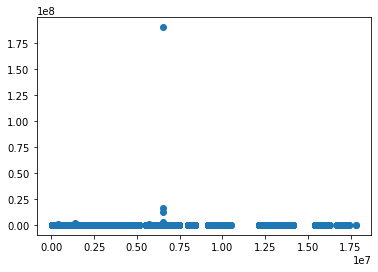

In [33]:
# Эмм.. 190 миллионов покупок какого-то одного товара...
plt.scatter(items.item_id, items.sales_sum)

In [37]:
data_train.week_no.max()

91

In [40]:
# Так - у нас 91 неделя, посчитаем сколько раз в неделю один человек должен был бы купить этот товар 
# (если бы каждый его покупал постоянно)
items.sales_sum.max()/data_train.user_id.unique().shape[0]/data_train.week_no.max()

836.501475315401

In [47]:
# Что это за товар такой вообще?
items.loc[(items.sales_sum > 10000000)]

,item_id,sales_sum,weight
55430,6533889,15978434,0.083996
55465,6534166,12439291,0.065391
55470,6534178,190227964,1.000000


In [51]:
# 3 товара продались более чем 10 миллионными количествами (один вообще почти 200 миллионов раз)
# Может я параною - но мне кажется это выброс. Такое количество покупок - это супер крупный опт какой-то )
# Ну - посмотрим, что это такое
item_features = pd.read_csv('product.csv')
item_features.loc[item_features.PRODUCT_ID == 6534178]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57221,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [52]:
item_features.loc[item_features.PRODUCT_ID == 6534166]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57216,6534166,69,MISC SALES TRAN,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [54]:
item_features.loc[item_features.PRODUCT_ID == 6533889]

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
57181,6533889,69,MISC SALES TRAN,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [55]:
# Это всё бензин какой-то.. Измеряется видимо литрами (или галлонами).. Так, ну может я зря параною, тогда.
# Возможно я неправильно мыслю - но я бы его убрал из списка супер-популярных. Как-то странно вообще рекомендовать
# всем подряд купить бензина.. Хотя если так думать - то надо вообще идти по списку - и наверное там много чего
# найдется, что было-бы странно рекомендовать (с моей частной точки зрения), но врядли это моя область компетенций..

In [81]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head()

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."


Сделайте предсказания

In [89]:
%%time

# your_code

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items, n=5))
result.head(2)

CPU times: user 4.06 s, sys: 44.8 ms, total: 4.11 s
Wall time: 4.3 s


,user_id,actual,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]"


In [91]:
# Ну вот. Бензин исправно рекомендуется к покупке всем )

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [94]:
result = pd.read_csv('predictions_basic.csv') # закгрузка predict с семианара
result.head(2)

FileNotFoundError: [Errno 2] File predictions_basic.csv does not exist: 'predictions_basic.csv'

In [95]:
# В материалах такого файла нет, видимо предполагается что мы их сделаем.. 
# Тогда сначала реализация остальных методов...

In [100]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [101]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [102]:
%%time

result['random_recommendation'] = result['user_id'].apply(lambda x: random_recommendation(items.item_id, n=5))
result.head(2)

CPU times: user 2.98 s, sys: 18.8 ms, total: 3 s
Wall time: 3.1 s


,user_id,actual,weighted_random_recommendation,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]","[2017058, 6463714, 1109352, 14077722, 13986780]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]","[1089442, 7466737, 1256340, 12648813, 9803295]"


In [103]:
# Для popularity_recommendation нужна sales_value
items = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items.columns = ('item_id', 'sales_value')
items.head(2)

,item_id,sales_value
0,25671,20.94
1,26081,0.99


In [106]:
%%time

result['popularity_recommendation'] = result['user_id'].apply(lambda x: popularity_recommendation(items, n=5))
result.head(2)

CPU times: user 29.7 s, sys: 210 ms, total: 29.9 s
Wall time: 30.8 s


,user_id,actual,weighted_random_recommendation,random_recommendation,popularity_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]","[2017058, 6463714, 1109352, 14077722, 13986780]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]","[1089442, 7466737, 1256340, 12648813, 9803295]","[6534178, 6533889, 1029743, 6534166, 1082185]"


In [110]:
# Для Item-Item Recommender мы на вебинаре брали только top5000  item_ids
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
top_5000[:10]

[6534178,
 6533889,
 6534166,
 6544236,
 1404121,
 397896,
 1426702,
 5703832,
 480014,
 5668996]

In [ ]:
# Всё те же бензины ))

In [125]:
# Сделаем два варианта. С товаром 999999 и без
data_train_999999 = data_train.copy()
data_train_999999.loc[~data_train_999999['item_id'].isin(top_5000), 'item_id'] = 999999

# Во второй таблице надо будет видимо просто удалить записи, не входящие в top5000
data_train_5000 = data_train.drop(data_train[~data_train['item_id'].isin(top_5000)].index)

In [128]:
user_item_matrix_999999 = pd.pivot_table(data_train_999999, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix_5000 = pd.pivot_table(data_train_5000, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

In [129]:
user_item_matrix_999999.shape, user_item_matrix_5000.shape

((2499, 5001), (2486, 5000))

In [130]:
# Ожидаемо - мы растеряли часть пользователей в трейне изза удаления строк.. 
# Это может нам аукнуться потом на предикте (рекоменде).

In [131]:
user_item_matrix_999999[user_item_matrix_999999 > 0] = 1
user_item_matrix_5000[user_item_matrix_5000 > 0] = 1

user_item_matrix_999999 = user_item_matrix_999999.astype(float)
user_item_matrix_5000 = user_item_matrix_5000.astype(float)

sparse_user_item_999999 = csr_matrix(user_item_matrix_999999).tocsr()
sparse_user_item_5000 = csr_matrix(user_item_matrix_5000).tocsr()

In [134]:
model_999999 = ItemItemRecommender(K=5, num_threads=4)
model_5000 = ItemItemRecommender(K=5, num_threads=4)

In [135]:
model_999999.fit(csr_matrix(user_item_matrix_999999).T.tocsr(),
          show_progress=True)

In [136]:
model_5000.fit(csr_matrix(user_item_matrix_5000).T.tocsr(),
          show_progress=True)

In [165]:
recs_999999 = model_999999.recommend(userid=1,
                        user_items=sparse_user_item_999999,
                        N=5,
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

In [166]:
recs_999999

[(2381, 78679.0),
 (3408, 72173.0),
 (2148, 57995.0),
 (3947, 17272.0),
 (3587, 14417.0)]

In [175]:
# Смутно предполагаю - что эти таплы - (id товара, рейтинг для этого товара в предсказании)
# Не очень понятно - зачем мы делали непрерывно индексированный вариант товаров и пользователей?
# Никакой внятной документации не встретилось по этой штуке - ItemItemRecommender.recommend имею ввиду.. 
# Он возвращает индекс товара из таблицы получается (если таблица user-item - то по сути номер столбца?)
# Который потом нужно перевести в реальный item_id
# А для юзера он возвращает номер строки - из которого можно потом понять user_id

# Проверим сейчас догадку, у большинства в рекомендациях должен быть товар 999999
for rec in recs_999999:
    print(user_item_matrix_999999.columns.values[rec[0]])

999999
1082185
981760
1127831
1098066


In [185]:
# Ну точно. И с юзерами видимо такая же история...
# Итак - по всем юзерам теперь...

userids_999999 = user_item_matrix_999999.index.values
matrix_userids_999999 = np.arange(len(userids_999999))
userid_to_id_999999 = dict(zip(userids_999999, matrix_userids_999999))

userids_5000 = user_item_matrix_5000.index.values
matrix_userids_5000 = np.arange(len(userids_5000))
userid_to_id_5000 = dict(zip(userids_5000, matrix_userids_5000))

# Для айтемов не будем делать - их вроде и в процессе удобно сопоставлять - как-то это утомительно просто )

In [187]:
%%time
result['itemitem_999999'] = result['user_id'].\
    apply(lambda x: [user_item_matrix_999999.columns.values[rec[0]] for rec in 
                    model_999999.recommend(userid=userid_to_id_999999[x], 
                                    user_items=sparse_user_item_999999,
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 84.1 ms, sys: 41.2 ms, total: 125 ms
Wall time: 156 ms


In [189]:
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popularity_recommendation,itemitem_999999
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]","[2017058, 6463714, 1109352, 14077722, 13986780]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]","[1089442, 7466737, 1256340, 12648813, 9803295]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]"


In [190]:
# И без 999999 товара
result['itemitem_5000'] = result['user_id'].\
    apply(lambda x: [user_item_matrix_5000.columns.values[rec[0]] for rec in 
                    model_5000.recommend(userid=userid_to_id_5000[x], 
                                    user_items=sparse_user_item_5000,
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

KeyError: 650

In [214]:
# Ну вот. Как и предполагалось в тесте оказался пользователь который был исключен из трейна.. 
# Нужна какая-то другая стратегия (как ограничить выборку товаров но сохранить всех пользователей при этом)
# Формально - сделаю вот что, получу 6 рекомендаций и исключу 999999-й из списка.

In [212]:
result.itemitem_999999.map(lambda x: x[0]).describe()

count      2042.0
mean     999999.0
std           0.0
min      999999.0
25%      999999.0
50%      999999.0
75%      999999.0
max      999999.0
Name: itemitem_999999, dtype: float64

In [213]:
# Ну - это так - на всякий случай - убедиться что эти id строго первыми стоят в рекомендациях всегда ))

In [216]:
result['itemitem_5000'] = result['user_id'].\
    apply(lambda x: [user_item_matrix_999999.columns.values[rec[0]] for rec in 
                    model_999999.recommend(userid=userid_to_id_999999[x], 
                                    user_items=sparse_user_item_999999,
                                    N=6, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [220]:
# Удаляем первую рекомендацию
result['itemitem_5000'] = result.itemitem_5000.map(lambda x: x[1:])
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popularity_recommendation,itemitem_999999,itemitem_5000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]","[2017058, 6463714, 1109352, 14077722, 13986780]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]","[1089442, 7466737, 1256340, 12648813, 9803295]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 995242, 826249]"


In [223]:
# Я конечно сильно извиняюсь - но почему у всех одинаковые рекомендации... ? И в на вебинаре ровно то-же самое ))

In [225]:
# Ладно, косинусное сходство
model = CosineRecommender(K=5, num_threads=4)
model.fit(csr_matrix(user_item_matrix_999999).T.tocsr(), 
          show_progress=True)

In [226]:
%%time

result['cosine_999999'] = result['user_id'].\
    apply(lambda x: [user_item_matrix_999999.columns.values[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id_999999[x], 
                                    user_items=sparse_user_item_999999,
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 91.1 ms, sys: 3.77 ms, total: 94.9 ms
Wall time: 111 ms


In [227]:
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popularity_recommendation,itemitem_999999,itemitem_5000,cosine_999999
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]","[2017058, 6463714, 1109352, 14077722, 13986780]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 999999, 981760, 1127831, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]","[1089442, 7466737, 1256340, 12648813, 9803295]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 999999, 826249]"


In [243]:
# Сделаю также без 999999-го для сравнения
result['cosine_5000'] = result['user_id'].\
    apply(lambda x: [user_item_matrix_999999.columns.values[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id_999999[x], 
                                    user_items=sparse_user_item_999999,
                                    N=6, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [245]:
result['cosine_5000'] = result.cosine_5000.map(lambda x: [i for i in x if i != 999999])
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popularity_recommendation,itemitem_999999,itemitem_5000,cosine_999999,cosine_5000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]","[2017058, 6463714, 1109352, 14077722, 13986780]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]","[1089442, 7466737, 1256340, 12648813, 9803295]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 1098066, 981760, 826249, 883404]"


In [246]:
# TFIDF
model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей
model.fit(csr_matrix(user_item_matrix_999999).T.tocsr(), show_progress=True)

In [247]:
%%time

result['tfidf_999999'] = result['user_id'].\
    apply(lambda x: [user_item_matrix_999999.columns.values[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id_999999[x], 
                                    user_items=sparse_user_item_999999,
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 86.7 ms, sys: 3.41 ms, total: 90.1 ms
Wall time: 98.1 ms


In [248]:
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popularity_recommendation,itemitem_999999,itemitem_5000,cosine_999999,cosine_5000,tfidf_999999
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]","[2017058, 6463714, 1109352, 14077722, 13986780]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 999999, 1098066]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]","[1089442, 7466737, 1256340, 12648813, 9803295]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 999999]"


In [249]:
# Ну и по традиции - без 999999
result['tfidf_5000'] = result['user_id'].\
    apply(lambda x: [user_item_matrix_999999.columns.values[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id_999999[x], 
                                    user_items=sparse_user_item_999999,
                                    N=6, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [250]:
result['tfidf_5000'] = result.tfidf_5000.map(lambda x: [i for i in x if i != 999999])
result.head(2)

,user_id,actual,weighted_random_recommendation,random_recommendation,popularity_recommendation,itemitem_999999,itemitem_5000,cosine_999999,cosine_5000,tfidf_999999,tfidf_5000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[6534178, 6534166, 6533889, 6544236, 5668996]","[2017058, 6463714, 1109352, 14077722, 13986780]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]","[1082185, 981760, 1127831, 999999, 1098066]","[1082185, 981760, 1127831, 1098066, 961554]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[970030, 6534178, 6533889, 6534166, 995242]","[1089442, 7466737, 1256340, 12648813, 9803295]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 995242, 826249]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 1098066, 981760, 826249, 883404]","[1082185, 981760, 1098066, 826249, 999999]","[1082185, 981760, 1098066, 826249, 883404]"


In [251]:
# Ну вот - теперь наконец можно приступать к измерениям )))
result.to_csv('recommendations.csv')

In [284]:
# your_code
def precision_at_k(recommended, actual, k=5):
    flags = np.isin(recommended[:k], actual)
    return flags.sum() / len(recommended[:k])

v_precision_at_k = np.vectorize(precision_at_k)

In [295]:
scores = []

In [296]:
scores.append(v_precision_at_k(result.cosine_999999, result.actual).mean())

In [297]:
scores.append(v_precision_at_k(result.cosine_5000, result.actual).mean())

In [298]:
scores.append(v_precision_at_k(result.itemitem_999999, result.actual).mean())

In [299]:
scores.append(v_precision_at_k(result.itemitem_5000, result.actual).mean())

In [300]:
scores.append(v_precision_at_k(result.tfidf_999999, result.actual).mean())

In [301]:
scores.append(v_precision_at_k(result.tfidf_5000, result.actual).mean())

In [302]:
scores.append(v_precision_at_k(result.random_recommendation, result.actual).mean())

In [303]:
scores.append(v_precision_at_k(result.weighted_random_recommendation, result.actual).mean())

In [304]:
methods = ('cosine_999999', 'cosine_5000', 'itemitem_999999', 'itemitem_5000', 'tfidf_999999', 'tfidf_5000',
          'random', 'weighted_random')
d = {'method': methods, 'score': scores}
sc = pd.DataFrame(d)
sc

,method,score
0,cosine_999999,0.132909
1,cosine_5000,0.155142
2,itemitem_999999,0.136925
3,itemitem_5000,0.151224
4,tfidf_999999,0.138981
5,tfidf_5000,0.160921
6,random,0.000588
7,weighted_random,0.047600


In [305]:
# Запредельные скоры

### Задание 3. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.
-  *Попробуйте стратегии ансамблирования изученных алгоритмов

Обязательно нужно сделать первые 2 пункта!

In [ ]:
# your_code

### Задание 4. Улучшение детерминированных алгоритмов
На семинаре мы рассматривали 



Далее $U \equiv N_i(u) $

$$r_{u,i} =  \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)r_{v, i}$$
$$ S = \sum\limits_{v \in U} \operatorname{sim}(u,v)$$

Предлагается улучшить эту формулу и учесть средние предпочтения всех пользователей

$$r_{u,i} = \mu + \bar{r_u} + \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)(r_{v, i}-\bar{r_{v}} - \mu)$$

Какие смысл имееют $ \mu $ и $ \bar{r_u}$ ?

Реализуйте алгоритм, прогнозирующий рейтинги на основе данной формулы, на numpy (векторизованно!)

В качестве схожести возьмите CosineSimilarity.

Примените к user_item_matrix. В качестве рейтингов возьмите количество или стоимость купленного товара. 
Данный алгоритм предсказывает рейтинги. Как на основании предсказанных рейтингов предсказать факт покупки?

Предложите вариант.
Посчитайте accuracy@5 и сравните с алгоритмами, разобранными на вебинаре.